# Bert Classifier for First ICU Prediction

## Import & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pickle

In [11]:
from utils.plots import *
from args import args
vars(args)

{'workdir': PosixPath('../data/work_dir/bert'),
 'dataset_csv': PosixPath('../data/processed_dataset.csv'),
 'bert_model': 'bert-base-mimic-cased',
 'bert_dir': PosixPath('../pretrained/pytorch-bert/bert-base-mimic-cased'),
 'max_seq_len': 256,
 'do_lower_case': False,
 'bs': 32,
 'device': 'cuda:0',
 'start_seed': 127,
 'cols': ['class_label', 'note'],
 'lr': 5e-05,
 'n_epochs': 5,
 'wd': 0.1,
 'warmup_prop': 0.1,
 'schedule': 'warmup_linear',
 'gradient_accumulation_steps': 1,
 'loss_scale': 0,
 'do_train': True,
 'do_eval': True,
 'bc_threshold': 0.5,
 'num_labels': 1,
 'labels': [0, 1],
 'n_gpu': 4}

In [9]:
with open(args.workdir/'pred.pkl', 'rb') as f:
  targ = pickle.load(f)
  pred = pickle.load(f)
  prob = pickle.load(f)

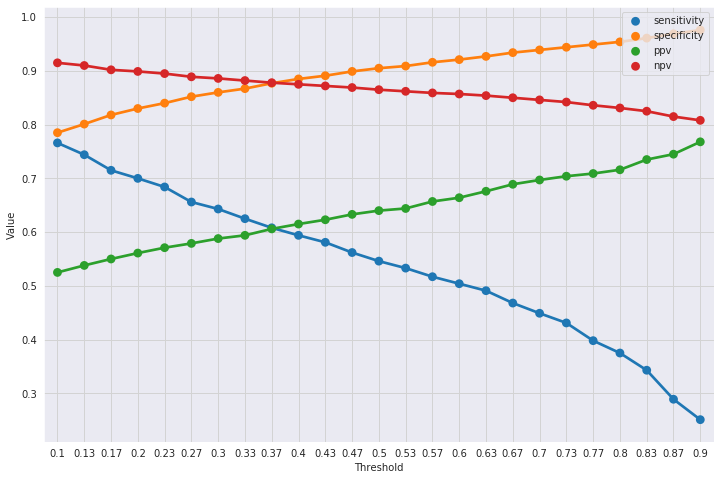

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, targ, prob, 0.1, 0.9, 25)

In [2]:
import pandas as pd
import pickle
import torch
from pathlib import Path

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import RandomSampler

In [3]:
from pytorch_pretrained_bert import BertTokenizer, BertAdam
from pytorch_pretrained_bert.modeling import BertForSequenceClassification

In [4]:
from data_processor import convert_examples_to_features, read_df
from optimizer import build_optimizer
from utils.splits import set_two_splits
from args import args
vars(args)

{'workdir': PosixPath('../data/work_dir/bert'),
 'dataset_csv': PosixPath('../data/processed_dataset.csv'),
 'bert_model': 'bert-base-mimic-cased',
 'bert_dir': PosixPath('../pretrained/pytorch-bert/bert-base-mimic-cased'),
 'max_seq_len': 512,
 'do_lower_case': False,
 'bs': 32,
 'device': 'cuda:0',
 'start_seed': 127,
 'cols': ['class_label', 'note'],
 'lr': 5e-05,
 'n_epochs': 1,
 'wd': 0.1,
 'warmup_prop': 0.1,
 'schedule': 'warmup_linear'}

## Data Setup

In [5]:
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)
df = set_two_splits(ori_df.copy(), 'val')
labels = 1-df['class_label'].unique()

In [ ]:
tokenizer = BertTokenizer.from_pretrained(args.bert_dir, do_lower_case=args.do_lower_case)
train_ex = read_df(df.loc[(df['split'] == 'train')], 'note', 'class_label')
train_feats = convert_examples_to_features(train_ex, labels, args.max_seq_len, tokenizer)
# val_ex = read_df(df.loc[(df['split'] == 'train')], 'note', 'class_label', set_type='val')
# val_feats = convert_examples_to_features(val_ex, args.labels, args.max_seq_len, tokenizer)

In [ ]:
input_ids = torch.tensor([f.input_ids for f in train_feats], dtype=torch.long)
input_mask = torch.tensor([f.input_mask for f in train_feats], dtype=torch.long)
segment_ids = torch.tensor([f.segment_ids for f in train_feats], dtype=torch.long)
label_ids = torch.tensor([f.label_id for f in train_feats], dtype=torch.long)

train_ds = TensorDataset(input_ids, input_mask, segment_ids, label_ids)

In [ ]:
train_dl = DataLoader(train_ds, sampler=RandomSampler(train_ds), batch_size=args.bs)
itr = iter(train_dl)

## Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(args.bert_dir, num_labels=1)
n_steps = (len(train_ds)//args.bs) * args.n_epochs
optimizer = build_optimizer(list(model.named_parameters()), n_steps, args.lr,
                            args.warmup_prop, args.wd, args.schedule)

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(args.device)

In [ ]:
model = torch.nn.DataParallel(model)

In [ ]:
batch = tuple(t.to(args.device) for t in next(itr))
iids, masks, sids, labels = batch

In [ ]:
pred = model(iids, sids, masks)
loss = loss_fn(pred.view(-1), labels.float())
print(loss.item())

In [ ]:
torch.cuda.empty_cache()